# Land Type Classification using Sentinel-2 Satellite Images

#### This project focuses on leveraging Deep Neural Networks (DNNs) to classify different land types (such as agriculture, water, urban areas, desert, roads, and trees).

## Step 1: Data Collection:

#### EuroSAT is a well-known dataset of Sentinel-2 satellite images designed for land use and land cover classification.
Download dataset [EuroSAT Dataset (RGB)](https://madm.dfki.de/files/sentinel/EuroSAT.zip)

#### Path to the dataset: 'EuroSAT/2750/' with 10 subfolders each containing around 2000-3000 images.

## Step 2: Data Exploration:

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter
import tensorflow as tf
import torch
import glob
import shutil
import random
from tqdm import tqdm

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.04G/2.04G [00:25<00:00, 87.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [5]:
dataset_path = path+'/EuroSAT'
print(os.listdir(dataset_path))

['SeaLake', 'AnnualCrop', 'label_map.json', 'Highway', 'Forest', 'validation.csv', 'Pasture', 'Industrial', 'Residential', 'River', 'train.csv', 'PermanentCrop', 'test.csv', 'HerbaceousVegetation']


In [8]:
# List all land type categories
categories = os.listdir(dataset_path)
for item in ['train.csv','test.csv','validation.csv']:
    if item in categories:
        categories.remove(item) # Remove only if present

categories

['SeaLake',
 'AnnualCrop',
 'label_map.json',
 'Highway',
 'Forest',
 'Pasture',
 'Industrial',
 'Residential',
 'River',
 'PermanentCrop',
 'HerbaceousVegetation']

## Step 3: Data Preprocessing:

In [11]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [12]:
# Define transformation (without normalization)
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

In [14]:
# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [15]:

def compute_mean_std(loader):
    mean = torch.zeros(3, dtype=torch.float64)
    std = torch.zeros(3, dtype=torch.float64)
    num_pixels = 0

    for images, _ in loader:
        batch_samples = images.shape[0]
        num_pixels += batch_samples * images.shape[2] * images.shape[3]  # Height * Width * Batch size

        # Sum means and squared values per channel
        mean += images.sum(dim=[0, 2, 3])
        std += (images ** 2).sum(dim=[0, 2, 3])

    mean /= num_pixels
    std = torch.sqrt(std / num_pixels - mean ** 2)  # std = sqrt(E[x^2] - (E[x])^2)

    return mean.tolist(), std.tolist()

# 🚀 Run optimized function
mean, std = compute_mean_std(loader)

print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")

Dataset Mean: [0.34437597334826436, 0.38029085127512613, 0.40777030097113715]
Dataset Std: [0.20266076750715076, 0.136896595010445, 0.11555012942640239]


In [16]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BICUBIC, fill=128),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# transforms.Grayscale(num_output_channels=1),  # we not Convert to grayscaleabs
# Keep RGB because color carries meaningful features.

# transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # well crop alot of details from images

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.0054, 0.0059, 0.0064], std=[0.0023, 0.0017, 0.0014])  # Use computed values
# ])

#### Why These Specific Transformations?
Data augmentation helps improve model generalization by introducing variations in the training data. Here’s why each transformation is useful:

- **`transforms.RandomHorizontalFlip(p=0.5)`**  
  - Flips the image horizontally with a 50% chance.  
  - Useful for datasets where objects can appear in either left or right orientations.  

- **`transforms.RandomVerticalFlip(p=0.5)`**  
  - Flips the image vertically with a 50% chance.  
  - Helpful for satellite or aerial images where features might not have a fixed orientation.  

- **`transforms.RandomRotation(15)`**  
  - Rotates the image randomly by up to ±15 degrees.  
  - Helps the model learn rotation-invariant features, useful for real-world scenarios where objects might not always be perfectly aligned.  

- **`transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`**  
  - Randomly adjusts brightness, contrast, saturation, and hue.  
  - Improves robustness to lighting variations and different weather conditions, making the model more adaptable to real-world images.  

These transformations enhance the diversity of the training data, reducing overfitting and improving the model’s performance. 🚀

- **`ToTensor()`** → Converts image to PyTorch tensor format.
- **`Normalize(mean, std)`** → Uses your dataset-specific values to improve model convergence and stability.

In [17]:
# Load Dataset with Transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

In [18]:
# Split the Dataset
train_size = int(0.7 * len(dataset))  # 70% Training
val_size = int(0.2 * len(dataset))    # 20% Validation
test_size = len(dataset) - train_size - val_size  # 10% Test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [19]:
# Create DataLoaders
# DataLoaders help in loading batches efficiently during training:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
train_loader.dataset.dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

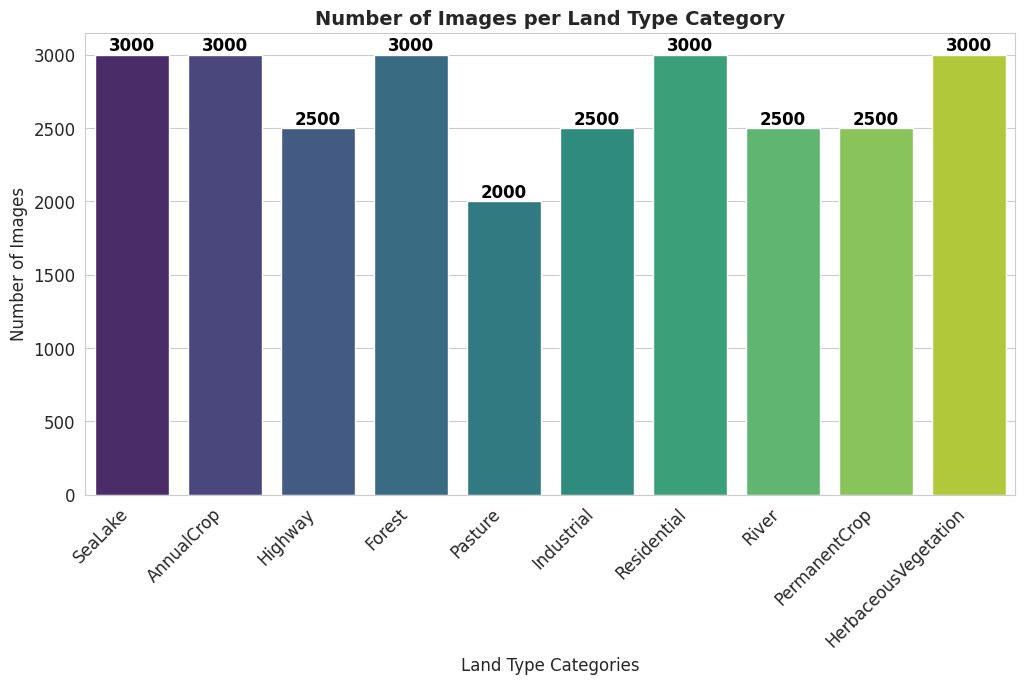

In [10]:
# Count the number of images per category
image_count = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path): # Check if the path is a directory before applying os.listdir()
        image_count[category] = len(os.listdir(category_path))

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot (fix: assign `x` to `hue` and disable legend)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), hue=list(image_count.keys()), palette="viridis", legend=False)

# Add exact counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Images per Land Type Category', fontsize=14, fontweight='bold')
plt.xlabel('Land Type Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()

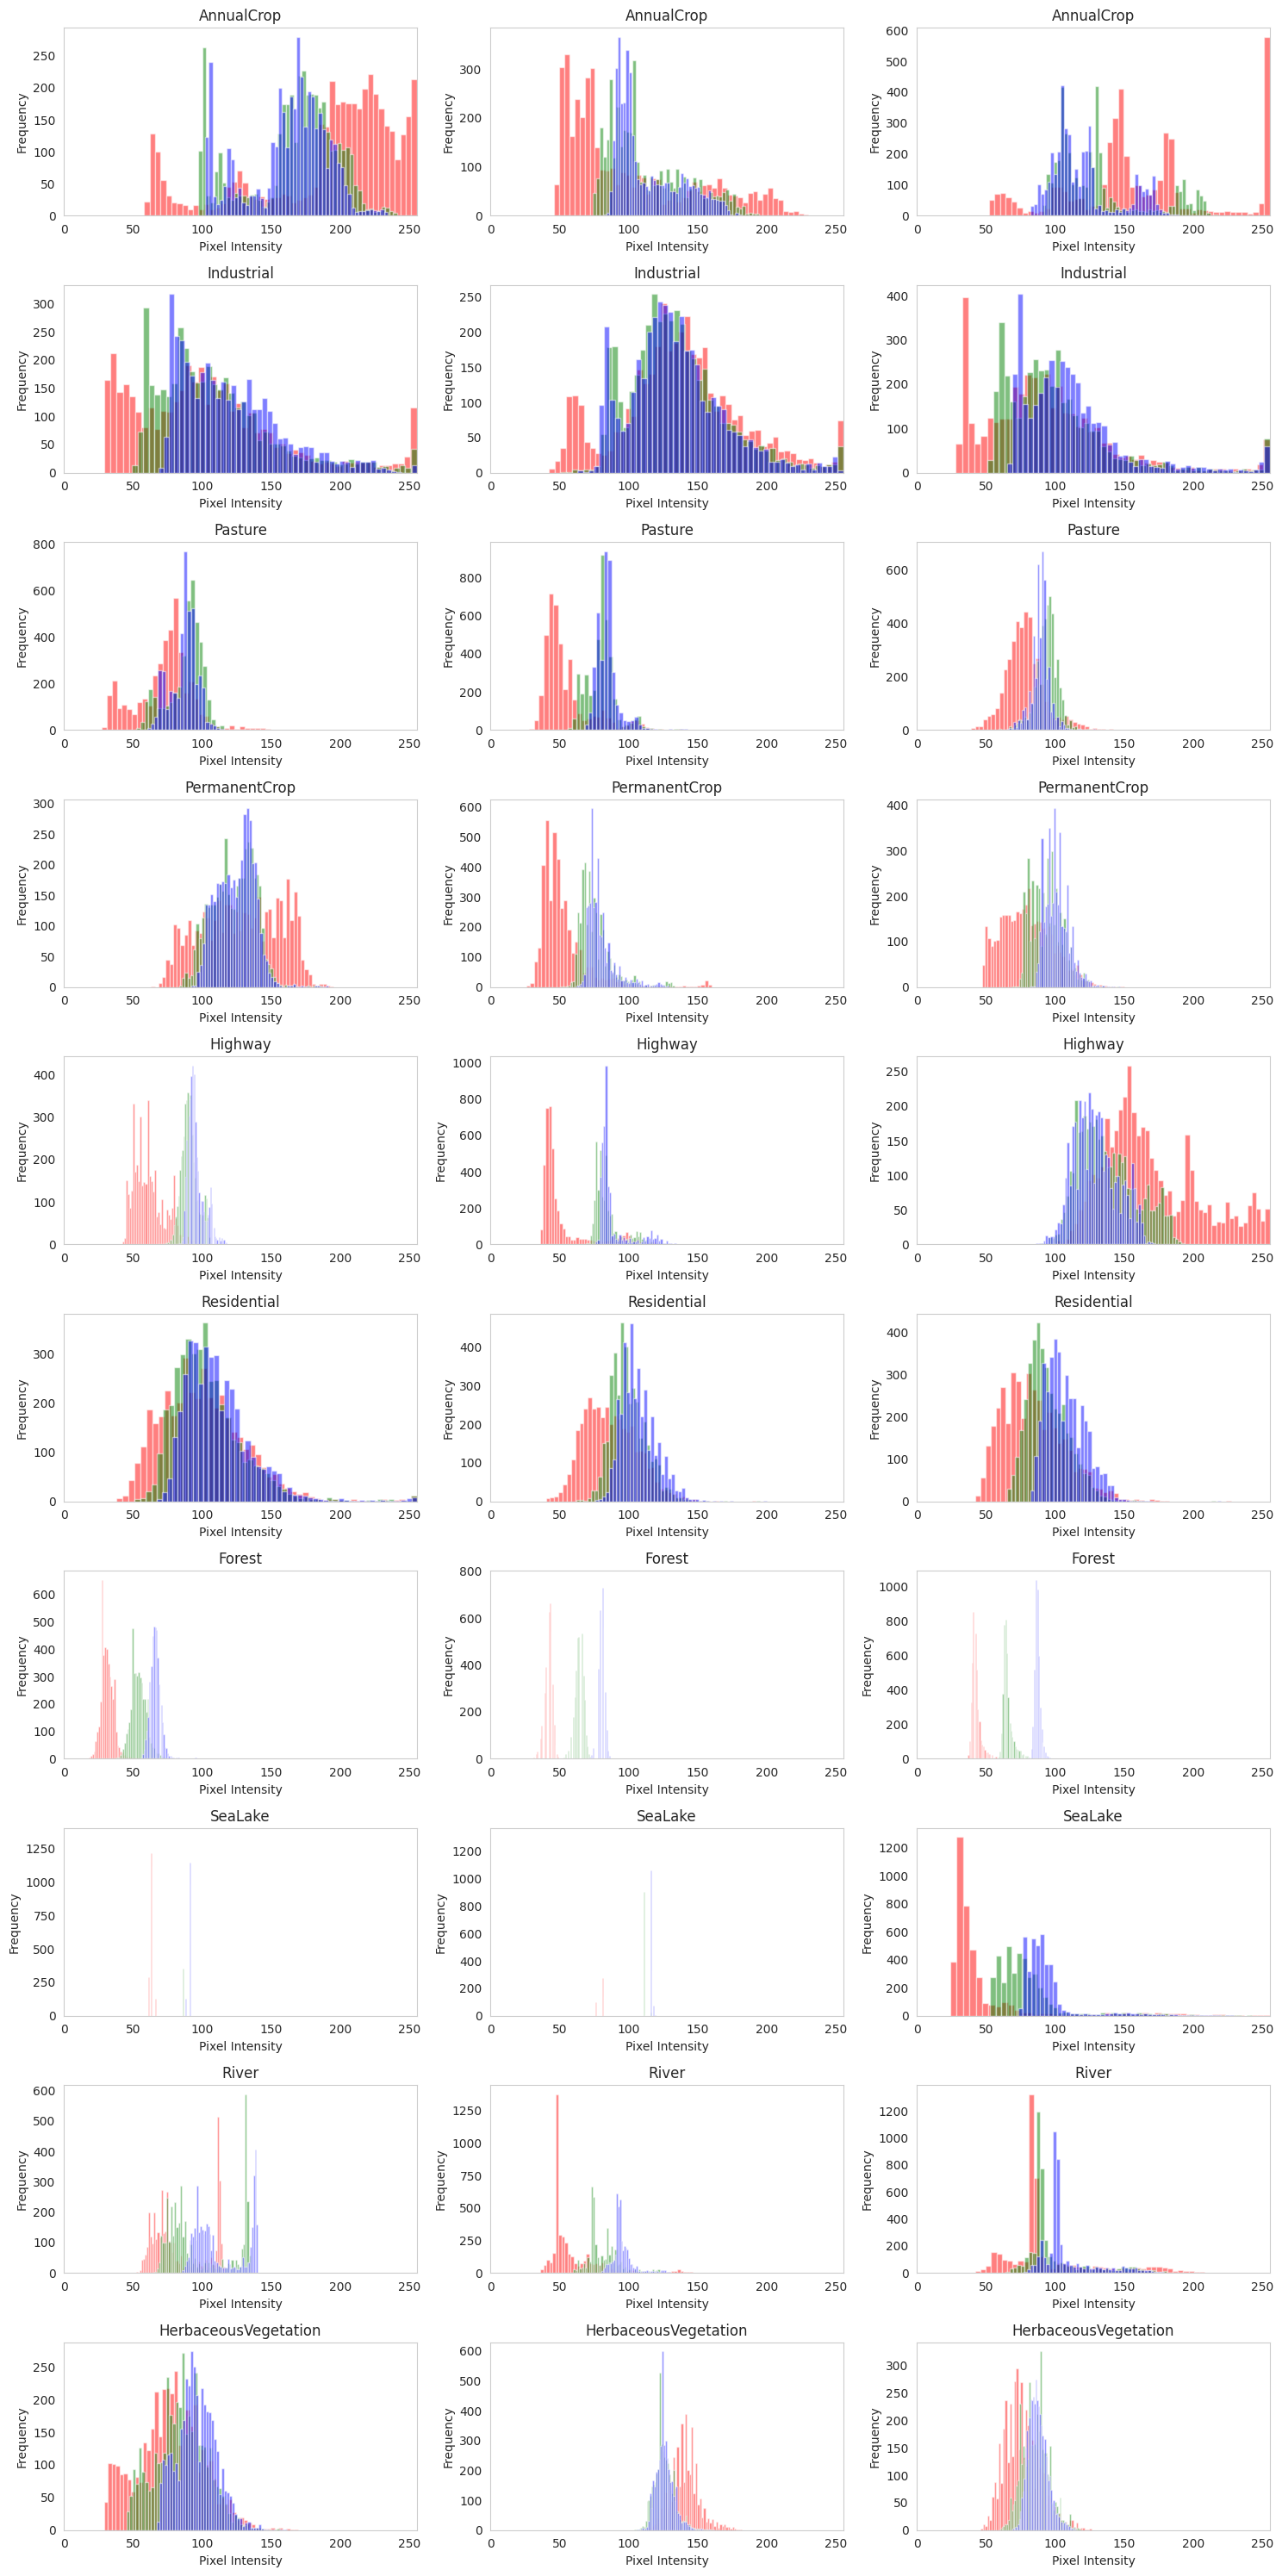

In [ ]:

import cv2
import os
import matplotlib.pyplot as plt
import math

# Function to plot pixel intensity distribution for each class
def plot_pixel_distribution(dataset_path, categories, num_samples=3):
    num_classes = len(categories)
    total_plots = num_classes * num_samples  # Total number of subplots

    # Define grid dynamically
    cols = min(num_samples, 3)  # Max 3 images per row for readability
    rows = math.ceil(total_plots / cols)  # Adjust rows accordingly

    plt.figure(figsize=(cols * 5, rows * 3))

    plot_idx = 1  # Track subplot index

    for category in categories:
        image_folder = os.path.join(dataset_path, category)

        # Ensure there are enough images to sample
        image_files = os.listdir(image_folder)
        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for image_name in sample_images:
            img_path = os.path.join(image_folder, image_name)
            img = cv2.imread(img_path)

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Ensure we don't exceed grid size
            if plot_idx > rows * cols:
                break

            plt.subplot(rows, cols, plot_idx)
            for channel, color in enumerate(['r', 'g', 'b']):
                plt.hist(img[:, :, channel].ravel(), bins=50, color=color, alpha=0.5)

            plt.title(f"{category}")
            plt.xlim([0, 255])
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
            plt.grid(False)

            plot_idx += 1  # Move to next subplot

    plt.tight_layout()
    plt.show()

# Visualize pixel distributions
plot_pixel_distribution(dataset_path, categories)



**Key Observations from Pixel Intensity Distribution Analysis**

The histograms show the pixel intensity distributions for different land types in the EuroSat dataset. Each subplot represents a land type, and the Red, Green, and Blue channels are visualized separately.

1️⃣ **Distinct Patterns for Different Land Types**
* **Vegetation-Based Classes (AnnualCrop, Pasture, PermanentCrop, Forest, HerbaceousVegetation)**

Green channel (G) is dominant, indicating a higher reflection of green light.
Red and Blue channels have lower intensity distributions.

* **Urban and Man-Made Areas (Residential, Industrial, Highway)**

More balanced distributions across Red, Green, and Blue.
Industrial areas and highways have flatter histograms, indicating a mix of materials (e.g., concrete, asphalt).

* **Water Bodies (SeaLake, River)**

Strong peaks in the Blue channel, indicating high reflection of blue light.
Red and Green channels have relatively lower intensity values.

2️⃣ Overlapping Distributions in Some Land Types
* **AnnualCrop vs. PermanentCrop**

Both show similar patterns, meaning they might be harder to separate using RGB values alone.
NDVI (Normalized Difference Vegetation Index) could help in better distinguishing them.

* **Forest vs. HerbaceousVegetation**

Similar intensity ranges in all three channels.
Extra features like texture analysis or spectral indices could improve differentiation.

3️⃣ Unique Trends in Specific Classes

* **Highway**

Has a unique shape with peaks in all three channels, suggesting a mix of materials (asphalt, road markings, shadows).

* **SeaLake & River**

Strong Blue channel dominance but a secondary spike in the Green channel.
This pattern aligns with water reflectance properties in optical imagery.

4️⃣ **Potential Preprocessing Needs**

* **Contrast Differences**

Some classes have skewed distributions (e.g., Forest and River have clustered values).
Histogram equalization or contrast adjustments might help normalize variations.

* **Normalization for Model Training**

Standardizing intensity values across channels could improve model generalization.


## 📊 Understanding the RGB Pixel Distribution Graph

### **Graph Explanation**
- **X-axis**: Represents **pixel intensity values** (0-255), where:
  - `0` → **Black** (lowest intensity)
  - `255` → **White** (highest intensity)
- **Y-axis**: Represents the **average frequency** of each intensity across all images.
- **Curves Represent Different Channels:**
  - 🔴 **Red Channel**
  - 🟢 **Green Channel**
  - 🔵 **Blue Channel**

### **📌 Key Insights from the Graph**
1. **Blue Dominance Around 80-100 Intensity**  
   - The blue curve has the highest peak around **80-100**.
   - This suggests that many images in the dataset contain **blueish tones** (e.g., water bodies, sky, or shadows).

2. **Green and Red Are More Spread Out**  
   - The **green curve** peaks between **50-100**, indicating the presence of **vegetation or natural elements**.
   - The **red curve** is more distributed, with peaks around **40-60**, suggesting the presence of **soil, buildings, or reddish tones**.

3. **Low Intensities (Shadows/Dark Areas)**  
   - The left side of the graph (0-50) shows noticeable activity in **red and green**, meaning some images have **dark or shadowed areas**.

4. **High Intensities (Bright Areas)**  
   - The right side of the graph (200-255) has lower values, meaning fewer **very bright areas** exist in the dataset.

#### Class Distribution Visualization (After Preprocessing)

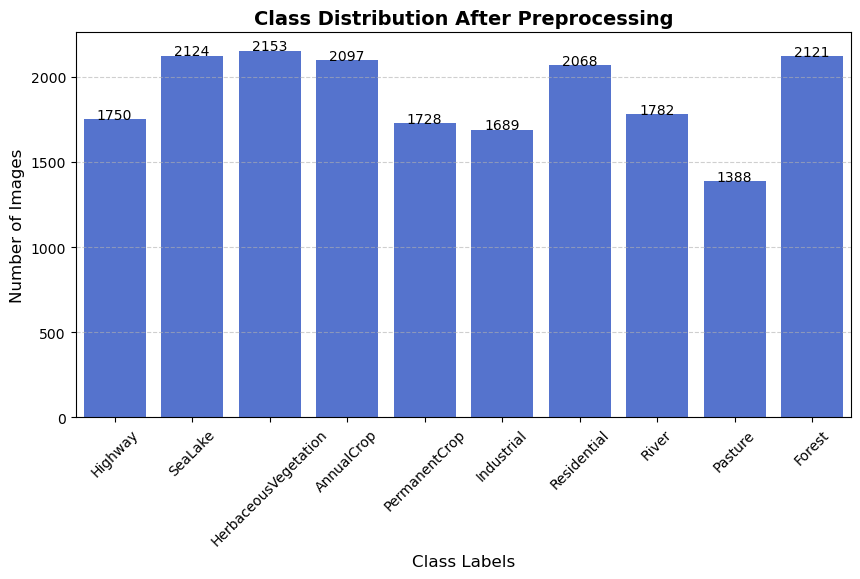

In [ ]:
# Extract class labels from the train dataset
labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
label_counts = Counter(labels)

# Convert to list format for seaborn
class_labels = [dataset.classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot using Seaborn
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=class_labels, y=counts, color="royalblue")

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Preprocessing (Training Data)", fontsize=14, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha="center", fontsize=10)

plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better visibility
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()